# Projekt 3 - ML


<b>TEMAT:</b> Estymacja zarobków developera/data scientista
<li>Predykcja zarobków pracownika IT na bazie corocznych ankiet stackoverflow. z lat 2017-2020.  Aplikacja przewidująca “ile powinienem zarabiać”.</li>
<li>Zbiór w dwóch wersjach - przeprocesowanej, gotowejdo użytku i w wersjisurowej. Gorąco zachęcam do eksplorowania danych surowych i korzystaniaze swoich pomysłów na preprocessing. Dostępne także ankiety z wcześniejszych lat pod adresem https://insights.stackoverflow.com/surveycodaje dodatkowe możliwości :)</li>

Główne cele projektu:
    <li>Machine learning</li>
    a. Obróbka i analiza danych - odrzucenie zbędnychzmiennych, przygotowaniedanych do modelowania etc.<br>
    b. Porównanie w zależności od typu problemu (regresja/klasyfikacja)różnegorodzaju modeli wraz z optymalizacją hiperparametrów<br>
    c. Zestawienie wyników z badań w formie adekwatnychwykresów i tabel.<br>
    d. Wszelkie inne dodatkowe rzeczy są na plus - np.zbadanie wpływu PCA na wyniki,weryfikacja interesujących hipotez o danych,w przypadku niektórych problemów zastosowanie zarówno podejścia regresyjnego,jak i  klasyfikacyjnego i co tamjeszcze sobie wymyślicie, możliwości zazwyczaj jest dużo :)<br>
    <li>Aplikacja</li>
    a. Prezentacja wartości biznesowej wynikającej z przygotowanegomodelu (np. poparte adekwatnymi wizualizacjami, tabelkami, możliwieinteraktywnymi). Jeśli to możliwe aplikacja powinnateż pozwalaćużytkownikowi na podanie wartości parametrów, pozwalającychuzyskać dla nich wynik najlepszego/wybranego modelu.<br>
    b. Jeśli umożliwiamy użytkownikowi podanie własnychdanych aplikacjapowinna je walidować, tj. możliwe powinno być podanietylko wartościz zakresu sensownego dla danej zmiennej.<br>
    c. Architektura aplikacji powinna wykorzystywać programowanie obiektowe.<br>

In [466]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV

plt.rcParams["figure.figsize"] = (20,6)
%matplotlib inline


In [488]:
df = pd.read_csv("survey_final.csv")


C:\Users\RAFAL_DELL\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [111]:
df.columns 

Index(['Year', 'Hobbyist', 'ConvertedComp', 'Country',
       'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'EdLevel',
       'Employment', 'JobSat', 'LanguageDesireNextYear', 'LanguageWorkedWith',
       'OrgSize', 'UndergradMajor', 'YearsCodePro'],
      dtype='object')

<li>Year - rok badania</li>
<li>Hobbyist - czy hobbistycznie (Yes/No -> 0/1)</li>
<li>ConvertedComp - sallary (nany odrzucamy?)</li>
<li>Country - kraj (grupowanie?)</li>
<li>DatabaseDesireNextYear - zapotrzebowanie na bazę w następnym roku - (split)</li>
<li>DatabaseWorkedWith - bazy z którymi pracował - (split)</li>
<li>DevType - typ dewelopera - (split)</li>
<li>EdLevel - edukacja (sprawdzić czy nie ma dziwnych)</li>
<li>Employment - zatrudnienie</li>
<li>JobSat - satysfakcja z pracy (sprawdzić czy nie ma dziwnych)</li>
<li>LanguageDesireNextYear - zapotrzebowanie na język - (split)</li>
<li>LanguageWorkedWith - używane języki - (split)</li>
<li>OrgSize - rozmiar organizacji (sprawdzić czy sa dziwne)</li>
<li>UndergradMajor - zakres działalności - (split)</li>
<li>YearsCodePro - ile przepracowanych lat (sprawdzić % nanów i skew - wypełnić przez mean/median)</li>

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303591 entries, 0 to 303590
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Year                    303591 non-null  int64  
 1   Hobbyist                303546 non-null  object 
 2   ConvertedComp           151172 non-null  float64
 3   Country                 302658 non-null  object 
 4   DatabaseDesireNextYear  200167 non-null  object 
 5   DatabaseWorkedWith      216942 non-null  object 
 6   DevType                 258928 non-null  object 
 7   EdLevel                 289916 non-null  object 
 8   Employment              297748 non-null  object 
 9   JobSat                  225834 non-null  object 
 10  LanguageDesireNextYear  248070 non-null  object 
 11  LanguageWorkedWith      257052 non-null  object 
 12  OrgSize                 226578 non-null  object 
 13  UndergradMajor          248486 non-null  object 
 14  YearsCodePro        

In [492]:
def clean_string_entries(df):
    df["EdLevel"].replace({
        "Associate degree (A.A., A.S., etc.)":"Associate degree",
        "Bachelor's degree (B.A., B.S., B.Eng., etc.":"Bachelor's degree",
        "Bachelor's degree (BA, BS, B.Eng., etc.)":"Bachelor's degree",
        "Bachelor‚'s degree (BA, BS, B.Eng., etc.)":"Bachelor's degree",
        "Bachelor's degree (B.A., B.S., B.Eng., etc.)":"Bachelor's degree",
        "Master's degree (M.A., M.S., M.Eng., MBA, etc.)":"Master's degree",
        "Master's degree (MA, MS, M.Eng., MBA, etc.)":"Master's degree",
        "Master‚'s degree (MA, MS, M.Eng., MBA, etc.)":"Master's degree",
        "Other doctoral degree (Ph.D, Ed.D., etc.)":"Doctoral degree",
        "Other doctoral degree (Ph.D., Ed.D., etc.)":"Doctoral degree",
        "Professional degree (JD, MD, etc.)":"Professional degree",
        "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)":"Secondary school",
        "Some college/university study without earning a bachelor's degree":"Some college/university study without earning a degree"
        }, inplace=True)
    df["Hobbyist"].replace({
        "Yes, I contribute to open source projects":"Yes",
        "Yes, I program as a hobby":"Yes",
        "Yes, both":"Yes"}, inplace=True)
    df["Country"].replace({
        "Azerbaidjan":"A`zerbaijan",
        "Bosnia-Herzegovina":"Bosnia and Herzegovina",
        "CÃ´te d'Ivoire":"Ivory Coast",
        "C√¥te d'Ivoire":"Ivory Coast",
        "Hong Kong (S.A.R.)":"Hong Kong",
        "Iran, Islamic Republic of...":"Iran",
        "Lao People's Democratic Republic":"Laos",
        "Libyan Arab Jamahiriya":"Libia",
        "Republic of Korea":"Korea",
        "South Korea":"Korea",
        "Saint Vincent & Grenadines":"Saint Vincent and the Grenadines",
        "Slovak Republic":"Slovakia",
        "Syrian Arab Republic":"Syria",
        "Tadjikistan":"Tajikistan",
        "United Republic of Tanzania":"Tanzania",
        "Venezuela, Bolivarian Republic of...":"Venezuela",
        "Viet Nam":"Vietnam",
        "Congo, Republic of the...":"Congo",
        "Ivory Coast (Cote D'Ivoire)":"Ivory Coast"
        }, inplace=True)
    df["OrgSize"].replace({"2-9 employees":"Fewer than 10 employees", 
        "2 to 9 employees":"Fewer than 10 employees", 
        "Just me - I am a freelancer, sole proprietor, etc.":"1 - freelancer, sole prioprietor, etc.",
        np.NaN: 'Fewer than 10 employees'
        }, inplace=True)
    df["Employment"].replace({
        'Retired' : 'not employed',
        'Not employed, and not looking for work' : 'not employed',
        'Not employed, but looking for work': 'not employed',
        }, inplace=True)
    df["JobSat"] = df["JobSat"].astype(str)
    df["JobSat"].replace({
        'Extremely dissatisfied': '1',
        'Very dissatisfied': '1',
        'Moderately dissatisfied': '1',
        '0.0': '1',
        '1.0': '1',
        '2.0': '1',
        '3.0': '1',
        'Slightly dissatisfied': '2',
        'Neither satisfied nor dissatisfied': '2',
        'Slightly satisfied': '2',
        '4.0': '2',
        '5.0': '2',
        '6.0': '2',
        'Moderately satisfied': '3',
        'Very satisfied': '3',
        'Extremely satisfied': '3',
        '7.0': '3',
        '8.0': '3',
        '9.0': '3',
        '10.0': '3',
        'nan': '2',
        np.NaN: '2'
        }, inplace=True)
    df['YearsCodePro'].replace({
        '0-2 years': '2',
        '1 to 2 years' : '2',
        '10 to 11 years' : '11',
        '11 to 12 years' : '12',
        '12 to 13 years' : '13',
        '12-14 years' : '13',
        '13 to 14 years' : '14',
        '14 to 15 years' : '15',
        '15 to 16 years' : '16',
        '15-17 years' : '16',
        '16 to 17 years' : '17',
        '17 to 18 years' : '18',
        '18 to 19 years' : '19',
        '18-20 years' : '19',
        '19 to 20 years' : '20',
        '2 to 3 years' : '3',
        '20 or more years' : '20',
        '21-23 years' : '22',
        '24-26 years' : '25',
        '27-29 years' : '28',
        '3 to 4 years' : '4',
        '30 or more years' : '30',
        '3-5 years' : '4',
        '4 to 5 years' : '5',
        '5 to 6 years' : '6',
        '6 to 7 years' : '7',
        '6-8 years' : '7',
        '7 to 8 years' : '8',
        '8 to 9 years' : '9',
        '9 to 10 years' : '10',
        '9-11 years' : '10',
        'Less than 1 year' : '1',
        'Less than a year' : '1',
        'More than 50 years' : '50',
        np.NaN: '0'
    }, inplace=True)
    df["EdLevel"].replace({
    "Associate degree (A.A., A.S., etc.)":"Associate degree",
    "Bachelor's degree (B.A., B.S., B.Eng., etc.":"Bachelor's degree",
    "Bachelor's degree (BA, BS, B.Eng., etc.)":"Bachelor's degree",
    "Bachelor‚'s degree (BA, BS, B.Eng., etc.)":"Bachelor's degree",
    "Bachelor's degree (B.A., B.S., B.Eng., etc.)":"Bachelor's degree",
    "Master's degree (M.A., M.S., M.Eng., MBA, etc.)":"Master's degree",
    "Master's degree (MA, MS, M.Eng., MBA, etc.)":"Master's degree",
    "Master‚'s degree (MA, MS, M.Eng., MBA, etc.)":"Master's degree",
    "Other doctoral degree (Ph.D, Ed.D., etc.)":"Doctoral degree",
    "Other doctoral degree (Ph.D., Ed.D., etc.)":"Doctoral degree",
    "Professional degree (JD, MD, etc.)":"Professional degree",
    "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)":"Secondary school",
    "Some college/university study without earning a bachelor's degree":"Some college/university study without earning a degree"
    }, inplace=True)

    return df

def split_dev_type(df):
    d = df["DevType"].str.get_dummies(sep=";")
    
    d["Academic, educator, researcher"] = d["Scientist"] + d["Academic researcher"] +  d["Educator or academic researcher"] + d["Educator"] 
    d["Data scientist or ML"] = d["Data scientist"] + d["Data scientist or machine learning specialist"] + d[" Data scientist"] + d["Engineer, data"] + d["Data or business analyst"] + d["Machine learning specialist"]+ d[" Machine learning specialist"] 
    d["Database admin"]= d[" Database administrator"] + d["Database administrator"]
    d["Desktop app dev"]= d[" Desktop applications developer"] + d["Developer, desktop or enterprise applications"] + d["Desktop applications developer"] + d["Desktop or enterprise applications developer"]
    d["System admin"]=d["Systems administrator"] + d["System administrator"]+ d[" Systems administrator"]
    d["Developer with stat"] = d[" Developer with a statistics or mathematics background"]+ d["Developer with a statistics or mathematics background"]
    d["Back-end dev"] = d["Back-end developer"] + d["Developer, back-end"]
    d["Graphic design"]=d[" Graphics programming"] + d["Graphics programming"] + d[" Graphic designer"] + d["Graphic designer"] + d["Designer"]
    d["Front-end dev"] = d["Front-end developer"] + d["Developer, front-end"]
    d["Full-stack dev"] = d["Full-stack developer"] + d["Developer, full-stack"]
    d["Game/graphics dev"] = d["Game or graphics developer"]+d["Developer, game or graphics"]
    d["QA/test eng"] = d["QA or test developer"] + d["Developer, QA or test"] + d["Quality assurance engineer"] + d[" Quality assurance engineer"]
    d["Mobile dev"] = d[" Mobile developer"] + d["Developer, mobile"] + d["Mobile developer"]
    d["DevOps"] =  d[" DevOps specialist"] + d["DevOps specialist"]
    d["Embedded Developer"]=d["Embedded applications/devices developer"]+d[" Embedded applications/devices developer"]+d["Embedded applications or devices developer"] +d["Developer, embedded applications or devices"]
    d["Other dev"] = d[" Other"] + d["Other"]
    d["CEO, CTO, etc"] = d["C-suite executive (CEO, CTO, etc.)"]
    d["Engineer of site reliability"] = d["Engineer, site reliability"]
    d["Engineering Manager"] = d["Engineering manager"]
    d["Marketing or sales Professional"] = d["Marketing or sales professional"]
    d["Product Manager"] = d["Product manager"]
    d["Senior Executive/VP"] = d["Senior executive/VP"]
    d["Students"] = d["Student"]
    d["Web developers"] = d["Web developer"]

    d1 = d.loc[:, 'Academic, educator, researcher':'Web developers']
    df_result = pd.concat([df, d1], axis=1)
    df_result = df_result.drop(columns=["DevType"], axis=1)
    return df_result

def split_db_worked_with(df):
    d_DatabaseWorkedWith = df["DatabaseWorkedWith"].str.get_dummies(sep=";")

    d_DatabaseWorkedWith["MongoDB_1"] = d_DatabaseWorkedWith[" MongoDB"] + d_DatabaseWorkedWith["MongoDB"]
    d_DatabaseWorkedWith["MySQL_1"] = d_DatabaseWorkedWith[" MySQL"] + d_DatabaseWorkedWith["MySQL"]
    d_DatabaseWorkedWith["Oracle_1"] = d_DatabaseWorkedWith[" Oracle"] + d_DatabaseWorkedWith["Oracle"]
    d_DatabaseWorkedWith["PostgreSQL_1"] = d_DatabaseWorkedWith[" PostgreSQL"] + d_DatabaseWorkedWith["PostgreSQL"]
    d_DatabaseWorkedWith["Redis_1"] = d_DatabaseWorkedWith[" Redis"] + d_DatabaseWorkedWith["Redis"]
    d_DatabaseWorkedWith["Microsoft_SQL_Server_1"] = d_DatabaseWorkedWith[" SQL Server"] + d_DatabaseWorkedWith["SQL Server"] + d_DatabaseWorkedWith["Microsoft SQL Server"]
    d_DatabaseWorkedWith["SQLite_1"] = d_DatabaseWorkedWith[" SQLite"] + d_DatabaseWorkedWith["SQLite"]
    d_DatabaseWorkedWith["Amazon_DynamoDB_1"] = d_DatabaseWorkedWith["Amazon DynamoDB"] + d_DatabaseWorkedWith["DynamoDB"]
    d_DatabaseWorkedWith["IBM_DB2_1"] = d_DatabaseWorkedWith["IBM DB2"] + d_DatabaseWorkedWith["IBM Db2"]
    d_DatabaseWorkedWith["MariaDB_1"] = d_DatabaseWorkedWith["MariaDB"]
    d_DatabaseWorkedWith["Amazon_RDS/Aurora_1"] = d_DatabaseWorkedWith["Amazon RDS/Aurora"]
    d_DatabaseWorkedWith["Amazon_Redshift_1"] = d_DatabaseWorkedWith["Amazon Redshift"]
    d_DatabaseWorkedWith["Apache_HBase_1"] = d_DatabaseWorkedWith["Apache HBase"]
    d_DatabaseWorkedWith["Apache_Hive_1"] = d_DatabaseWorkedWith["Apache Hive"]
    d_DatabaseWorkedWith["Cassandra_1"] = d_DatabaseWorkedWith["Cassandra"]
    d_DatabaseWorkedWith["Couchbase1"] = d_DatabaseWorkedWith["Couchbase"]
    d_DatabaseWorkedWith["Elasticseach_1"] = d_DatabaseWorkedWith["Elasticsearch"]
    d_DatabaseWorkedWith["Firebase_1"] = d_DatabaseWorkedWith["Firebase"]
    d_DatabaseWorkedWith["Google_BigQuery_1"] = d_DatabaseWorkedWith["Google BigQuery"]
    d_DatabaseWorkedWith["Google_Cloud_Storage_1"] = d_DatabaseWorkedWith["Google Cloud Storage"]
    d_DatabaseWorkedWith["Memcached_1"] = d_DatabaseWorkedWith["Memcached"]
    d_DatabaseWorkedWith["Microsoft_Azure_(Tables, CosmosDB, SQL, etc)_1"] = d_DatabaseWorkedWith["Microsoft Azure (Tables, CosmosDB, SQL, etc)"]
    d_DatabaseWorkedWith["Neo4j_1"] = d_DatabaseWorkedWith["Neo4j"]
    d_DatabaseWorkedWith["Other_1"] = d_DatabaseWorkedWith["Other(s):"]

    d_DatabaseWorkedWith = d_DatabaseWorkedWith.loc[:, "MongoDB_1":"Other_1" ]

    d_DatabaseWorkedWith = d_DatabaseWorkedWith.replace({
        2:1,
        3:1,
        4:1,
        5:1,
        6:1,
        7:1,
        8:1,
        9:1,
        10:1})

    df_result = pd.concat([df, d_DatabaseWorkedWith], axis=1)
    df_result = df_result.drop(columns=["DatabaseWorkedWith"], axis=1)
    return df_result

def split_language_worked_with(df):
    d4 = df["LanguageWorkedWith"].str.get_dummies(sep=";")

    d4["C++_lang"] = d4[" C"] + d4[" C#"] + d4[" C++"]+d4["C"]+d4["C#"]+d4["C++"]
    d4["Common_Lisp_lang"] = d4["Common Lisp"]
    d4["Clojure_lang"] = d4[" Clojure"] + d4["Clojure"]
    d4["CoffeeScript_lang"] = d4[" CoffeeScript"]+d4["CoffeeScript"]
    d4["Dart_lang"] = d4[" Dart"]+d4["Dart"]
    d4["Elixir_lang"] = d4[" Elixir"]+d4["Elixir"]
    d4["Erlang_lang"] = d4[" Erlang"]+d4["Erlang"]
    d4["F#_lang"] = d4[" F#"]+d4["F#"]
    d4["Go_lang"] = d4[" Go"]+d4["Go"]
    d4["Groovy_lang"] = d4[" Groovy"]+d4["Groovy"]
    d4["Hack_lang"] = d4[" Hack"]+d4["Hack"]
    d4["Haskell_lang"] = d4[" Haskell"]+d4["Haskell"]
    d4["Java_lang"] = d4[" Java"]+d4["Java"]
    d4["JavaScript_lang"] = d4[" JavaScript"]+d4["JavaScript"]
    d4["Julia_lang"] = d4[" Julia"]+d4["Julia"]
    d4["Lua_lang"] = d4[" Lua"]+d4["Lua"]
    d4["Matlab_lang"] = d4[" Matlab"]+d4["Matlab"]
    d4["Objective-C_lang"] = d4[" Objective-C"]+d4["Objective-C"]
    d4["Perl_lang"] = d4[" Perl"]+d4["Perl"]
    d4["PHP_lang"] = d4[" PHP"]+d4["PHP"]
    d4["Python_lang"] = d4[" Python"]+d4["Python"]
    d4["R_lang"] = d4[" R"]+d4["R"]
    d4["Ruby_lang"]=d4[" Ruby"]+d4["Ruby"]
    d4["Rust_lang"] = d4[" Rust"]+d4["Rust"]
    d4["Scala_lang"] = d4[" Scala"]+d4["Scala"]
    d4["Smalltalk_lang"] = d4[" Smalltalk"]+d4["Smalltalk"]
    d4["SQL_lang"] = d4[" SQL"]+d4["SQL"]
    d4["Swift_lang"] = d4[" Swift"]+d4["Swift"]
    d4["TypeScript_lang"] = d4[" TypeScript"]+d4["TypeScript"]
    d4["VB.NET_lang"] = d4[" VB.NET"]+d4["VB.NET"]
    d4["VBA_lang"] = d4[" VBA"]+d4["VBA"]+d4["Visual Basic 6"]+d4[" Visual Basic 6"]
    d4["WebAssembly_lang"] = d4["Assembly"]+d4["WebAssembly"]
    d4["Cobol_lang"] = d4["Cobol"]
    d4["Delphi/Object_Pascal_lang"] = d4["Delphi/Object Pascal"]
    d4["HTML/CSS_lang"] = d4["HTML"]+d4["HTML/CSS"]+d4["CSS"]
    d4["Kotlin_lang"] = d4["Kotlin"]
    d4["Bash/Shell/PowerShell_lang"] = d4["Bash/Shell/PowerShell"]+d4["Bash/Shell"]
    d4["Ocaml_lang"] = d4["Ocaml"]
    d4["Other_lang"] = d4["Other(s):"]

    d4 = d4.loc[:, 'C++_lang':'Other_lang']

    d4 = d4.replace({
        2:1,
        3:1,
        4:1,
        5:1,
        6:1,
        7:1,
        8:1,
        9:1,
        10:1})

    df_result = pd.concat([df, d4], axis=1)
    df_result = df_result.drop(columns=["LanguageWorkedWith"], axis=1)
    return df_result

def split_hobbyist(df):
    df_result = pd.get_dummies(df, columns=['Hobbyist', 'Employment', 'OrgSize'], drop_first=True)
    return df_result

def clean_data(df):
    df2 = df.dropna(subset = ["ConvertedComp"])
    df2 = df2[df2['ConvertedComp']>0]
    df3 = clean_string_entries(df2)
    df4 = df3.drop(["DatabaseDesireNextYear","LanguageDesireNextYear", "UndergradMajor", 'Country', 'EdLevel'], axis=1)
    df5 = split_language_worked_with(df4)
    df6 = split_db_worked_with(df5)
    df7 = split_dev_type(df6)
    df8 = split_hobbyist(df7)
    df8['YearsCodePro'] = df8['YearsCodePro'].astype('int')
    df8['JobSat'] = df8['JobSat'].astype('int')
    
    return df8


In [493]:
df2 = clean_data(df)

In [498]:
class RandomTree():
    def __init__(self, df, target='ConvertedComp'):
        self.df = df
        self.X, self.Y = self.split_xy(target)
        self.sc = StandardScaler()
        self.X_sc = self.sc.fit_transform(self.X)
        self.Y_log = np.log(self.Y)
        self.model = self.grid_search()
        
    def grid_search(self):
        params = {
            'max_depth': [10, 15, 20, 30],
            'min_samples_leaf': [10, 15, 20, 30]
        }
        forest = RandomForestRegressor()
        gs = GridSearchCV(forest, param_grid=params, scoring='neg_mean_squared_error', cv=5)
        gs.fit(self.X_sc, self.Y_log)
        model = gs.best_estimator_
        print(f'Score (rmse) for random forest is: {-gs.best_score_}')
        return model

    def predict(self, x):
        x = self.sc.transform(x)
        predict = np.e ** self.model.predict(x)
        return predict

    def split_xy(self, target):
        X = self.df.drop(target, axis=1)
        Y = self.df[target]
        return X, Y

In [458]:
tree = RandomTree(df2)

Score (rmse) for random forest is: 1.260467997663652


In [459]:
tree.model

RandomForestRegressor(max_depth=20, min_samples_leaf=15)

In [526]:
Pkl_Filename = "Pickle_Tree_Model.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(tree, file)

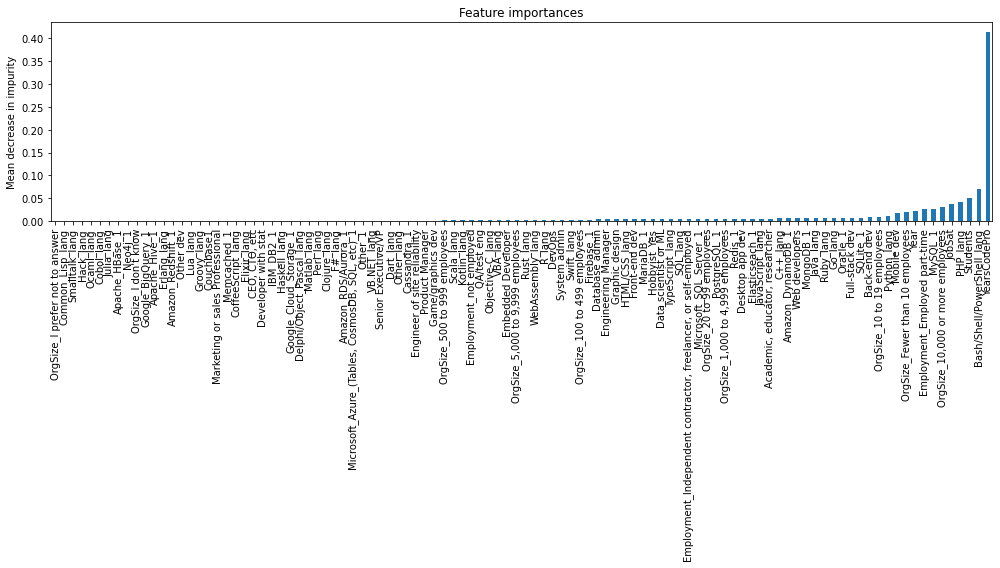

In [522]:
feature_columns = df2.drop('ConvertedComp', axis=1).columns

importances = tree.model.feature_importances_
forest_importances = pd.Series(importances, index=feature_columns).sort_values()

fig, ax = plt.subplots(figsize=(14,8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [523]:
forest_importances

OrgSize_I prefer not to answer    0.000000
Common_Lisp_lang                  0.000000
Smalltalk_lang                    0.000000
Hack_lang                         0.000002
Ocaml_lang                        0.000004
                                    ...   
JobSat                            0.037506
PHP_lang                          0.041881
Students                          0.051488
Bash/Shell/PowerShell_lang        0.070376
YearsCodePro                      0.413967
Length: 104, dtype: float64

In [525]:
Y_pred = tree.predict(df2[feature_columns])
rmse = mean_squared_error(df2['ConvertedComp'].reset_index(drop=True), Y_pred, squared=False)
print(f'Score (rmse) for random forest is: {rmse}')


Score (rmse) for random forest is: 236092.25565123645


In [496]:
class HalvingTree():
    def __init__(self, df, target='ConvertedComp'):
        self.df = df
        self.X, self.Y = self.split_xy(target)
        self.sc = StandardScaler()
        self.X_sc = self.sc.fit_transform(self.X)
        self.Y_log = np.log(self.Y)
        self.model = self.grid_search()
        
    def grid_search(self):
        params = {
            'max_depth': [10, 15, 20, 30],
            'min_samples_leaf': [10, 15, 20, 30],
            'max_features': [20, 40, 60, 100],
            'min_impurity_decrease': [0.0005, 0.0001, 0.00005]
        }
        forest = RandomForestRegressor()
        gs = HalvingGridSearchCV(forest, param_grid=params, scoring='neg_mean_squared_error', cv=5, verbose=1)
        gs.fit(self.X_sc, self.Y_log)
        model = gs.best_estimator_
        print(f'Score (rmse) for random forest is: {-gs.best_score_}')
        return model

    def predict(self, x):
        x = self.sc.transform(x)
        predict = np.e ** self.model.predict(x)
        return predict

    def split_xy(self, target):
        X = self.df.drop(target, axis=1)
        Y = self.df[target]
        return X, Y

In [497]:
tree_halving = HalvingTree(df2)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1851
max_resources_: 149983
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 192
n_resources: 1851
Fitting 5 folds for each of 192 candidates, totalling 960 fits
----------
iter: 1
n_candidates: 64
n_resources: 5553
Fitting 5 folds for each of 64 candidates, totalling 320 fits
----------
iter: 2
n_candidates: 22
n_resources: 16659
Fitting 5 folds for each of 22 candidates, totalling 110 fits
----------
iter: 3
n_candidates: 8
n_resources: 49977
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 3
n_resources: 149931
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Score (rmse) for random forest is: 1.2508014265965683


In [515]:
Y_pred = tree_halving.predict(df2.drop('ConvertedComp', axis=1))
rmse = mean_squared_error(df2['ConvertedComp'], Y_pred, squared=False)
print(f'Score (rmse) for random forest is: {rmse}')

Score (rmse) for random forest is: 255283.41976173111


In [501]:
tree_halving.model

RandomForestRegressor(max_depth=20, max_features=40,
                      min_impurity_decrease=5e-05, min_samples_leaf=10)

In [518]:
importances = tree_halving.model.feature_importances_
forest_importances = pd.Series(importances, index=df2.drop('ConvertedComp', axis=1).columns).sort_values(ascending=False)
forest_importances

Full-stack dev                      0.411084
Employment_Employed part-time       0.071887
Students                            0.048470
HTML/CSS_lang                       0.041903
OrgSize_5,000 to 9,999 employees    0.036687
                                      ...   
Smalltalk_lang                      0.000000
Swift_lang                          0.000000
Other_lang                          0.000000
Oracle_1                            0.000000
Senior Executive/VP                 0.000000
Length: 104, dtype: float64

In [512]:
tree_halving.df = None
tree_halving.X = None
tree_halving.Y = None
tree_halving.X_sc = None
tree_halving.Y_log = None

Pkl_Filename = "Pickle_Tree_Model.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(tree_halving, file)

In [519]:
class RandomTree():
    def __init__(self, df, target='ConvertedComp'):
        X, Y = self.split_xy(df, target)
        Y_log = np.log(Y)
        self.model = self.grid_search(X, Y_log)
        
    def grid_search(self, X, Y):
        params = {
            'max_depth': [20],
            'max_features': [40],
            'min_impurity_decrease': [5e-05],
            'min_samples_leaf': [10]
        }
        forest = RandomForestRegressor()
        gs = GridSearchCV(forest, param_grid=params, scoring='neg_mean_squared_error', cv=5)
        gs.fit(X, Y)
        model = gs.best_estimator_
        return model

    def predict(self, x):
        predicted = np.e ** self.model.predict(x)
        return predicted

    def split_xy(self, df, target):
        X = df.drop(target, axis=1)
        Y = df[target]
        return X, Y

In [520]:
tree = RandomTree(df2)

In [527]:
Y_pred = tree.predict(df2[feature_columns])
rmse = mean_squared_error(df2['ConvertedComp'].reset_index(drop=True), Y_pred, squared=False)
print(f'Score (rmse) for random forest is: {rmse}')

Score (rmse) for random forest is: 236092.25565123645


In [529]:
diff = np.abs(Y_pred - df2['ConvertedComp'])
diff

7         47609.356362
9          7626.790346
10         2561.410709
11        22597.324665
12        57371.325051
              ...     
303570    32501.637316
303577    73943.205248
303581    12631.956490
303586    35336.431383
303589    11849.206257
Name: ConvertedComp, Length: 149983, dtype: float64

In [534]:
print(diff.mean(), diff.std(), diff.count())

71055.33801538288 225146.68573291015 149983


In [535]:
small_diff = diff[diff<250000]
print(small_diff.mean(), small_diff.std(), small_diff.count())

28589.743518742744 28972.949647821493 142865


<AxesSubplot:>

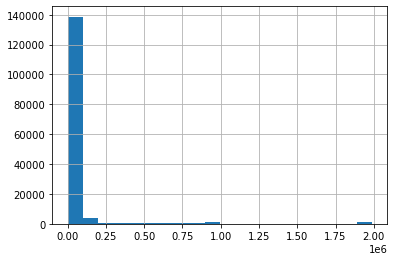

In [532]:
diff.hist(bins=20)

<AxesSubplot:>

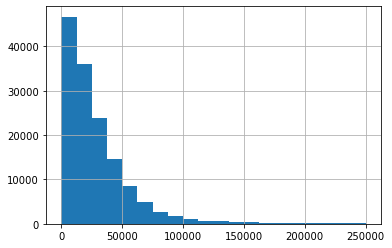

In [539]:
diff[diff<250000].hist(bins=20)